In [81]:
# this version allows us to modify look-forward period. Load everything, use all variables, but look forward more time steps.
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('df PS and weather.csv', index_col = 0, parse_dates=True)

In [82]:
# set up routine to predict ahead some time period
look_forward = 48   #time to predict is look_forward*15 min 

y = df.iloc[:,0].shift(periods=look_forward)
df = df.drop(df.columns[[0]], axis=1) 
df = pd.concat([y, df], axis=1)
df = df[look_forward:-look_forward]
# df.head(15)


In [83]:
X = df.iloc[:, 1:] #everything except first column
y = df.iloc[:, 0:1] #select response variable

from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()


X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

#first 30000 for training

X_train = X_ss[:35000, :]
X_test = X_ss[35000:, :]

y_train = y_mm[:35000, :]
y_test = y_mm[35000:, :] 

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (35000, 74) (35000, 1)
Testing Shape (4741, 74) (4741, 1)


In [84]:
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

#reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))


X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([35000, 1, 74]) torch.Size([35000, 1])
Testing Shape torch.Size([4741, 1, 74]) torch.Size([4741, 1])


In [85]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length
        ## THIS PART DEFINES THE PIECES OF THE NEURAL NETWORK, BUT NOT YET PUT TOGETHER
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 32) #fully connected 1
        self.fc = nn.Linear(32, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        
        # THIS PART DEFINES THE ORDER IN WHICH INFORMATION IS PASSED THROUGH THE NETWORK, AND ITS ARCHITECTURE
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        #hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = output.view(-1,64) #reshape the output to the right dimension
        out, (hn,cn) = self.lstm(out) #MAKE ANOTHER PASS THROUGH LSTM
        out = out.view(-1,64) #reshape the lstm output to the right dimension
        out = self.relu(out)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [86]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.01 #0.001 lr

input_size = X_train.shape[1] #number of features
hidden_size = 64 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class 
print (lstm1)

LSTM1(
  (lstm): LSTM(74, 64, batch_first=True)
  (fc_1): Linear(in_features=64, out_features=32, bias=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)


In [87]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))



Epoch: 0, loss: 0.41175
Epoch: 100, loss: 0.00319
Epoch: 200, loss: 0.00238
Epoch: 300, loss: 0.00176
Epoch: 400, loss: 0.00130
Epoch: 500, loss: 0.00098
Epoch: 600, loss: 0.00080
Epoch: 700, loss: 0.00065
Epoch: 800, loss: 0.00064
Epoch: 900, loss: 0.00052


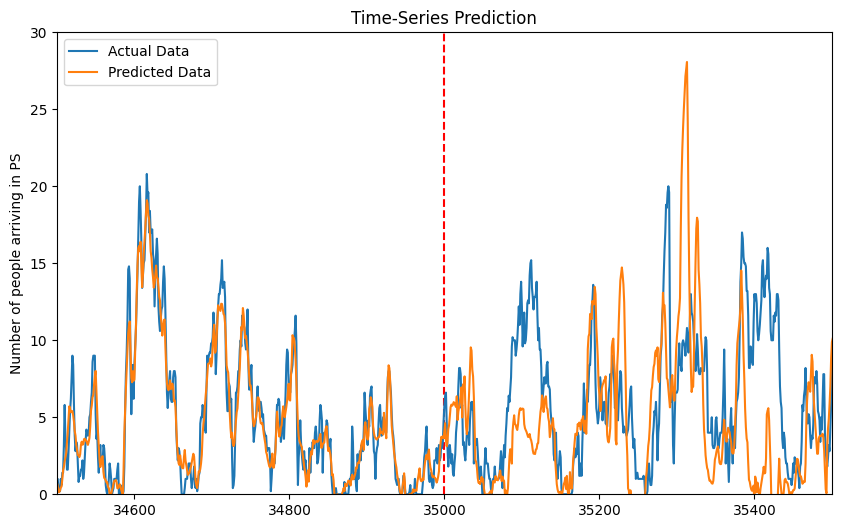

In [88]:

df_X_ss = ss.transform(df.iloc[:, 1:]) #old transformers
df_y_mm = mm.transform(df.iloc[:, 0:1]) #old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 

train_predict = lstm1(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=35000, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actual Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.ylabel('Number of people arriving in PS')
plt.legend()


ax = plt.gca()
xmin = 34500  
xmax = 35500
ymin = 0
ymax = 30
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

plt.show() 

Now we can see just how hard it is to predict the future. 